In [1]:
import os
import tensorflow
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import sys
!pip install hdf5storage
import hdf5storage as hdf5

sys.path.insert(0,"/content/drive/My Drive/Hyperspectral")

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir("/content/gdrive/MyDrive/Hyperspectral/")
print(os.getcwd())
!pip install hdf5storage
import datasets
import models
import cv2

     |████████████████████████████████| 53 kB 1.4 MB/s 
Mounted at /content/gdrive
/content/gdrive/MyDrive/Hyperspectral


In [2]:
# load firmness
#inputPath = "c:\\users\\nalina\\Documents\\tomato_firmness\\hsdata\\firmness.csv"
inputPath = "/content/gdrive/MyDrive/Hyperspectral/hsdata/firmness.csv"
df = datasets.load_firmness_attributes(inputPath)
df.shape

(494, 1)

In [ ]:
#load the hyperspectral images of tomatoes (3 channels) and scale the pixel 
rgbPath = "/content/gdrive/MyDrive/Hyperspectral/rgb"
#img = cv2.imread(rgbPath + "/" + "t18.jpeg")
#print(img.shape)

#images = datasets.load_produce_images(df_sub, inputPath)
inputImages = []
fileCount = 1
for i in df.index.values:
  if fileCount < 18:
    #print(fileCount)
    img = cv2.imread(rgbPath + "/" + i + ".jpg")
  else:
    img = cv2.imread(rgbPath + "/" + i + ".jpeg")
    #print(rgbPath + "/" + i + ".jpeg")
  #print(img.shape)
  img = img[0:482, 0:512, :]
  img = cv2.resize(img, (256, 256))
  #img_reshaped = img.reshape(img.shape[0], -1)
  #np.savetxt((img_path + i + ".txt"), img_reshaped, fmt='%d')
  inputImages.append(img)
  fileCount += 1

In [ ]:
inputImages = np.array(inputImages)
inputImages.shape

In [ ]:
split = train_test_split(df, inputImages, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

trainY = np.log(trainAttrX["firmness"])
testY = np.log(testAttrX["firmness"])

In [ ]:
# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# predicted firmness and the actual firmness
model = models.create_cnn(256, 256, 3, regress=True)
opt = Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(x=trainImagesX, y=trainY, validation_data=(testImagesX, testY), epochs=125, batch_size=32) #try epochs=200 if this works, error goes down until 125

#firmness predictions for test data
#firmness_preds = model.predict(testImagesX)

#compute the difference between the firmness predictions and the actual firmness values, then compute the percentage 
#difference and the absolute percentage difference
#diff = firmness_preds.flatten() - testY
#percent_diff = (diff / testY) * 100
#absPercentDiff = np.abs(percent_diff)

#mean and std deviation of absolute percentage difference
#mean = np.mean(absPercentDiff)
#std = np.abs(absPercentDiff)
#######################################

#print("Avg. firmness " + str(df["firmness"].mean()))
#print("Std. Dev. firmness " + str(df["firmness"].std()))

#print("Mean and std. dev. of predictions " + str(mean) + " " + str(std))

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
#testY = testAttrX["firmness"] / maxFirmness
#firmness predictions for test data
firmness_preds = model.predict(testImagesX)
testY = pd.DataFrame(testY)
testY['preds'] = firmness_preds.flatten()
testY.to_csv("/content/gdrive/MyDrive/Hyperspectral/hsdata/test_preds_256rs_125epochs_v3.csv", index=False)

In [ ]:
d = {'train_loss': history.history['loss'], 'test_loss': history.history['val_loss']}
model_acc = pd.DataFrame(d)
model_acc.to_csv("/content/gdrive/MyDrive/Hyperspectral/hsdata/model_acc_256rs_125epochs_v3.csv", index=False)

In [3]:
################# NEURAL NETWORK ############################
#load the hyperspectral images of tomatoes (31 channels) and scale the pixel to 128 or 64 for NN since only a single dimension can be input 128*128*31 or 64*64*31
rgbPath = "/content/gdrive/MyDrive/Hyperspectral/rgb"
inputNNImages = []
fileCount = 1
for i in df.index.values:
  if fileCount < 18:
    img = cv2.imread(rgbPath + "/" + i + ".jpg")
  else:
    img = cv2.imread(rgbPath + "/" + i + ".jpeg")
  img = img[0:482, 0:512, :]
  img = cv2.resize(img, (128, 128))
  inputNNImages.append(img)
  fileCount += 1

In [4]:
inputNNImages = np.array(inputNNImages)

In [5]:
inputNNImages.shape

(494, 128, 128, 3)

In [6]:
split = train_test_split(df, inputNNImages, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

trainY = np.log(trainAttrX["firmness"])
testY = np.log(testAttrX["firmness"])

In [7]:
#flatten the trainImagesX and testImagesX to convert from 3 dimensions to 1 dimension
nn_trainx = trainImagesX.reshape(trainImagesX.shape[0],-1)
nn_testx = testImagesX.reshape(testImagesX.shape[0],-1)
print(nn_trainx.shape)


(370, 49152)


In [8]:
# create our Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# predicted firmness and the actual firmness
model = models.create_mlp(49152, regress=True)
opt = Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

nn_history = model.fit(x=nn_trainx, y=trainY, validation_data=(nn_testx, testY), epochs=125, batch_size=32) #try epochs=200 if this works

#firmness predictions for test data
nn_firmness_preds = model.predict(nn_testx)

#compute the difference between the firmness predictions and the actual firmness values, then compute the percentage 
#difference and the absolute percentage difference
#nn_diff = firmness_preds.flatten() - testY
#nn_percent_diff = (nn_diff / testY) * 100
#nn_absPercentDiff = np.abs(nn_percent_diff)

#mean and std deviation of absolute percentage difference
#nn_mean = np.mean(nn_absPercentDiff)
#nn_std = np.abs(nn_absPercentDiff)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/125
12/12 [==============================] - 1s 20ms/step - loss: 2423.1143 - val_loss: 7.0447
Epoch 2/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0177 - val_loss: 7.0442
Epoch 3/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0172 - val_loss: 7.0435
Epoch 4/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0165 - val_loss: 7.0428
Epoch 5/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0158 - val_loss: 7.0420
Epoch 6/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0150 - val_loss: 7.0412
Epoch 7/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0140 - val_loss: 7.0402
Epoch 8/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0131 - val_loss: 7.0392
Epoch 9/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0120 - val_loss: 7.0381
Epoch 10/125
12/12 [==============================] - 0s 8ms/step - loss: 7.0109 - val_loss: 7.0370
Epoch

dict_keys(['loss', 'val_loss'])


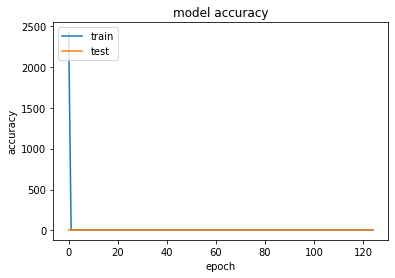

In [10]:
import matplotlib.pyplot as plt

print(nn_history.history.keys())
# summarize history for accuracy
plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
import pandas as pd
#testY = testAttrX["firmness"] / maxFirmness
#firmness predictions for test data
nn_firmness_preds = model.predict(nn_testx)
testY = pd.DataFrame(testY)
testY['preds'] = nn_firmness_preds.flatten()
testY.to_csv("/content/gdrive/MyDrive/Hyperspectral/hsdata/nn_test_preds_256rs_125epochs_rgb.csv", index=False)

In [12]:
d = {'train_loss': nn_history.history['loss'], 'test_loss': nn_history.history['val_loss']}
model_acc = pd.DataFrame(d)
model_acc.to_csv("/content/gdrive/MyDrive/Hyperspectral/hsdata/nn_model_acc_256rs_125epochs_rgb.csv", index=False)